In [1]:
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(style = 'white', color_codes = True)
%matplotlib inline

import sys
import os

import os
cwd = os.getcwd()

sys.path.append(cwd[:-len('befit/examples/temp_rev_learn')])

import torch
torch.set_default_dtype(torch.float64)

## Load behavioral data

In [2]:
os.chdir(cwd + '/pilot')
responses = np.load('responses.npy')

T1 = 600
T2 = 800

mask_all = torch.from_numpy((~np.isnan(responses)).astype(np.uint8))
mask = mask_all[:, T1:T2]
responses_all = torch.from_numpy(np.nan_to_num(responses).astype(np.long))
responses = responses_all[:, T1:T2]

offers_all = torch.from_numpy(np.load('offers.npy')).long()
offers = offers_all[:, T1:T2]
outcomes = torch.from_numpy(np.load('outcomes.npy')).double()
outcomes[outcomes < 2] = (outcomes[outcomes < 2] + 1)/2
outcomes[torch.isnan(outcomes)] = 0.
outcomes_all = outcomes.long()
outcomes = outcomes_all[:, T1:T2]

stimulus = {'offers': offers, 
           'outcomes': outcomes,
           'mask': mask.double()}

blocks, trials, nsub = responses.shape
evidence = torch.zeros(3, nsub)  # per subject model evidence
n_samples = 1000  # number of samples from posterior

## Plotting functions

In [3]:
def errorplot(*args, **kwargs):
    subjects = args[0]
    values = args[1]
    percentiles = args[2]

    
    low_perc = values[percentiles == '5th']
    up_perc = values[percentiles == '95th']
    
    x = subjects[percentiles == 'median']
    y = values[percentiles == 'median']
    
    kwargs['yerr'] = [y.values-low_perc.values, up_perc.values-y.values]
    kwargs['linestyle'] = ''
    kwargs['marker'] = 'o'
    
    plt.errorbar(x.values, 
                 y.values, 
                 **kwargs)

## Fit behavioural models

In [4]:
from befit.agents import RLTempRevLearn, BayesTempRevLearn
from befit.inference import Horseshoe, Normal

In [5]:
#Fit RL agent
rl_agent = RLTempRevLearn(runs=nsub, trials=trials)
rl_agent.set_parameters()

mask[0, :50] = 0

rl_infer = Horseshoe(rl_agent, stimulus, responses, mask=mask)
rl_infer.infer_posterior(iter_steps=200)

Mean ELBO 1384.52: 100%|██████████| 200/200 [11:50<00:00,  3.65s/it]


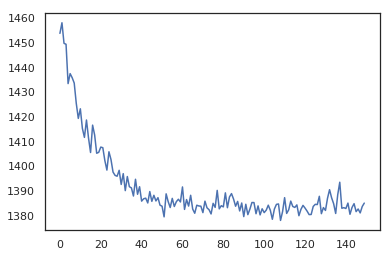

In [6]:
plt.figure()
plt.plot(rl_infer.loss[-150:]);

labels = [r'$\alpha$', r'$\kappa$', r'$\beta$', r'$\theta$']
tp_df = rl_infer.sample_posterior(labels, n_samples=1000)

trans_pars_rl = tp_df[0].melt(id_vars='subject', var_name='parameter')

rl_par_names = ['alpha', 'kappa', 'beta', 'bias']
rl_df = rl_infer.formated_results(rl_par_names)

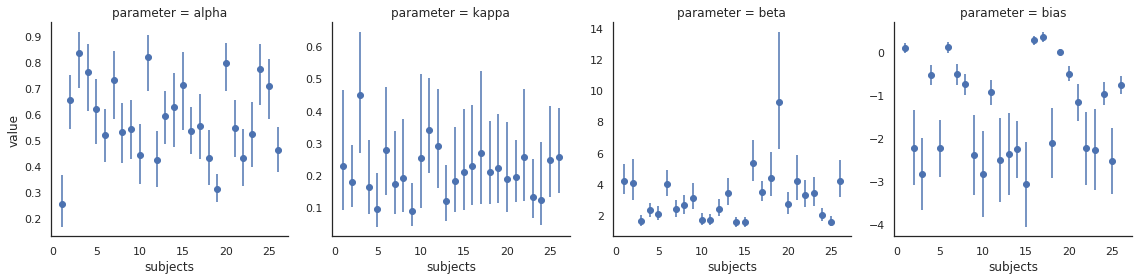

In [9]:
g = sns.FacetGrid(rl_df, col="parameter", height=4, sharey=False);
g = (g.map(errorplot, 'subjects', 'value', 'variables'));

In [5]:
#Fit EDHMM agent
edhmm_agent = BayesTempRevLearn(runs=nsub, trials=trials)
edhmm_agent.set_parameters()

mask[0, :50] = 0

edhmm_infer = Horseshoe(edhmm_agent, stimulus, responses, mask=mask)
edhmm_infer.infer_posterior(iter_steps=200)

Mean ELBO 3795.73:  10%|█         | 21/200 [09:14<1:17:03, 25.83s/it]/mnt/data/miniconda/envs/pyro-ppl/lib/python3.7/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
Mean ELBO    nan:  11%|█         | 22/200 [09:40<1:16:54, 25.92s/it] /mnt/data/miniconda/envs/pyro-ppl/lib/python3.7/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
Mean ELBO    nan:  12%|█▏        | 23/200 [10:07<1:16:40, 25.99s/it]/mnt/data/miniconda/envs/pyro-ppl/lib/python3.7/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
Mean ELBO    nan:  12%|█▏        | 24/200 [10:33<1:16:14, 25.99s/it]/mnt/data/miniconda/envs/pyro-ppl/lib/python3.7/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
Mean ELBO    nan:  12%|█▎        | 25/200 [10:59<1:15:57, 26.04s/it]/mnt/data/miniconda/envs/pyro-ppl/lib/

Mean ELBO    nan:  29%|██▉       | 58/200 [25:37<1:03:27, 26.81s/it]/mnt/data/miniconda/envs/pyro-ppl/lib/python3.7/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
Mean ELBO    nan:  30%|██▉       | 59/200 [26:03<1:02:30, 26.60s/it]/mnt/data/miniconda/envs/pyro-ppl/lib/python3.7/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
Mean ELBO    nan:  30%|███       | 60/200 [26:30<1:01:55, 26.54s/it]/mnt/data/miniconda/envs/pyro-ppl/lib/python3.7/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
Mean ELBO    nan:  30%|███       | 61/200 [26:57<1:01:58, 26.75s/it]/mnt/data/miniconda/envs/pyro-ppl/lib/python3.7/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
Mean ELBO    nan:  31%|███       | 62/200 [27:24<1:01:47, 26.87s/it]/mnt/data/miniconda/envs/pyro-ppl/lib/py

Mean ELBO    nan:  48%|████▊     | 95/200 [42:20<47:50, 27.33s/it]/mnt/data/miniconda/envs/pyro-ppl/lib/python3.7/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
Mean ELBO    nan:  48%|████▊     | 96/200 [42:48<47:42, 27.53s/it]/mnt/data/miniconda/envs/pyro-ppl/lib/python3.7/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
Mean ELBO    nan:  48%|████▊     | 97/200 [43:15<46:58, 27.36s/it]/mnt/data/miniconda/envs/pyro-ppl/lib/python3.7/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
Mean ELBO    nan:  49%|████▉     | 98/200 [43:41<45:51, 26.97s/it]/mnt/data/miniconda/envs/pyro-ppl/lib/python3.7/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
Mean ELBO    nan:  50%|████▉     | 99/200 [44:07<44:38, 26.52s/it]/mnt/data/miniconda/envs/pyro-ppl/lib/python3.7/si

KeyboardInterrupt: 

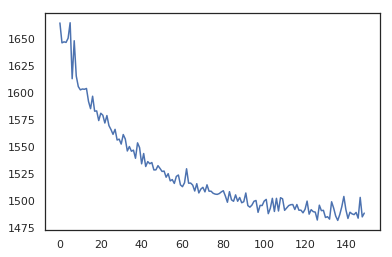

In [8]:
plt.figure()
plt.plot(edhmm_infer.loss[-150:]);

labels = [r'$\delta$', r'$\rho$', r'$\beta$', r'$\lambda$', r'ph', r'pl']
edhmm_tp_df = edhmm_infer.sample_posterior(labels, n_samples=1000)

trans_pars_rl = edhmm_tp_df[0].melt(id_vars='subject', var_name='parameter')

edhmm_par_names = ['delta', 'rho', 'beta', 'lam', 'ph', 'pl']
edhmm_df = edhmm_infer.formated_results(edhmm_par_names)

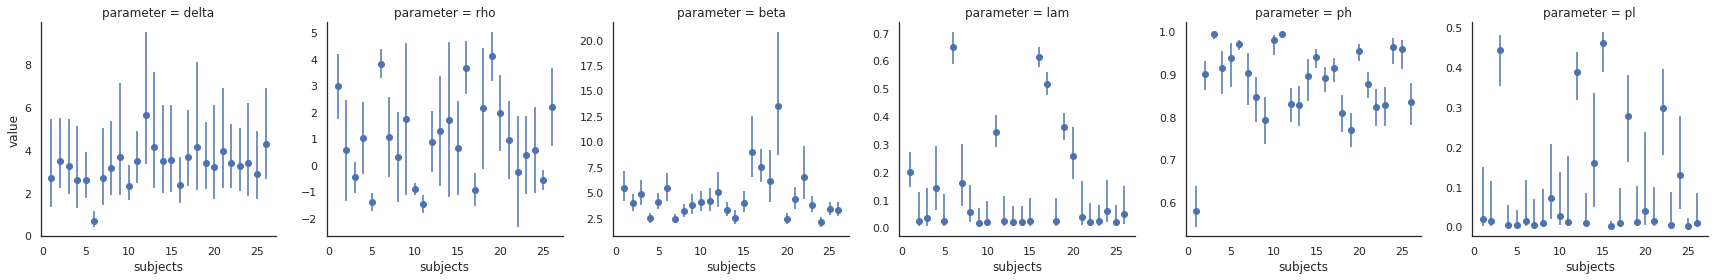

In [9]:
g = sns.FacetGrid(edhmm_df, col="parameter", height=4, sharey=False);
g = (g.map(errorplot, 'subjects', 'value', 'variables'));

(0, 2)

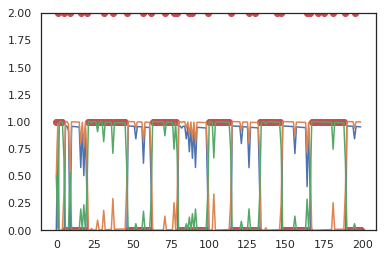

In [15]:
sub = 5
plt.plot(torch.stack(edhmm_agent.values)[:,sub,0].detach().numpy());
plt.plot(responses[0, :, sub].numpy(), 'ro');

plt.plot(torch.stack(edhmm_agent.beliefs)[:-1].sum(-1)[:, sub, :].detach().numpy());
plt.ylim([0, 2])

In [16]:
em_edhmm = edhmm_infer.get_log_evidence_per_subject(num_particles = 200)
print(em_edhmm)

tensor([-56.8235, -34.0175, -52.0150, -85.2104, -63.1729, -50.7200, -84.5264,
        -59.6819, -50.0654, -70.8661, -78.3418, -56.8922, -43.7805, -83.1343,
        -68.5856, -39.7417, -64.9587, -27.7349, -14.1012, -78.5776, -27.3123,
        -44.6234, -40.3376, -95.3883, -72.2717, -43.7046])


In [20]:
torch.arange(nsub)[(responses_all == 2)[0].sum(-2) > 10]


tensor([ 0,  3,  5,  6,  7, 10, 13, 15, 16, 18, 19, 20, 23, 24, 25])

In [ ]:
# performe sequential parameter estimate and model selection

rl_agent = RLTempRevLearn(runs=nsub, trials=trials)
rl_agent.set_parameters()

posterior_samples_rl = []
model_evidences_rl = []
for i in range(20):
    T1 = 50*i
    T2 = 50*i + 200
    mask = mask_all[:, T1:T2]
    offers = offers_all[:, T1:T2]
    outcomes = outcomes_all[:, T1:T2]
    responses = responses_all[:, T1:T2]
    stimulus = {'offers': offers, 
                'outcomes': outcomes,
                'mask': mask.double()}
    
    mask = mask[:, :50] = 0
    rl_infer = Horseshoe(rl_agent, stimulus, responses, mask=mask)
    rl_infer.infer_posterior(iter_steps=200)
    
    labels = [r'$\alpha$', r'$\kappa$', r'$\beta$', r'$\theta$']
    posterior_samples_rl.append(rl_infer.sample_posterior(labels, n_samples=1000))
    
    model_evidences_rl.append(rl_infer.get_log_evidence_per_subject(num_particles = 200))

In [10]:

edhmm_agent = BayesTempRevLearn(runs=nsub, trials=trials)
edhmm_agent.set_parameters()

posterior_samples_edhmm = []
model_evidences_edhmm = []
for i in range(20):
    T1 = 50*i
    T2 = 50*i + 200
    mask = mask_all[:, T1:T2]
    offers = offers_all[:, T1:T2]
    outcomes = outcomes_all[:, T1:T2]
    responses = responses_all[:, T1:T2]
    stimulus = {'offers': offers, 
                'outcomes': outcomes,
                'mask': mask.double()}
    
    mask = mask[:, :50] = 0
    edhmm_infer = Horseshoe(edhmm_agent, stimulus, responses, mask=mask)
    edhmm_infer.infer_posterior(iter_steps=200)
    
    labels = [r'$\alpha$', r'$\kappa$', r'$\beta$', r'$\theta$']
    posterior_samples_edhmm.append(ed_hmm_infer.sample_posterior(labels, n_samples=1000))
    
    model_evidences_edhmm.append(edhmm_infer.get_log_evidence_per_subject(num_particles = 200))
    